In [3]:
%pip install imagehash

In [4]:
import os
import shutil
import hashlib
import imagehash
import numpy as np
from PIL import Image
import tensorflow as tf
from pathlib import Path
from tensorflow import keras
from matplotlib import pyplot as plt
from sklearn.model_selection import GroupShuffleSplit
from tensorflow.keras import layers, regularizers, mixed_precision
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve, f1_score
import seaborn as sns
import logging
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.callbacks import LearningRateScheduler

logging.basicConfig(level=logging.WARNING)

In [5]:
def setup_gpu():
    gpus = tf.config.list_physical_devices('GPU')
    if gpus:
        try:
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
            print(f"{len(gpus)} GPU(s) available and configured")
        except RuntimeError as e:
            print(e)
    else:
        print("No GPU available, running of CPU")

In [6]:
setup_gpu()

1 GPU(s) available and configured


In [7]:
MODE = "deterministic"

np.random.seed(42)
tf.random.set_seed(42)
os.environ["PYTHONHASHSEED"] = "0"
tf.keras.utils.set_random_seed(42)

if MODE == "deterministic":
  tf.config.experimental.enable_op_determinism()
  os.environ['TF_DETERMINISTIC_OPS'] = '1'
if MODE == "performance":
  tf.config.optimizer.set_jit(True)

In [8]:
mixed_precision.set_global_policy("mixed_float16")

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
source_dir = Path('/content/drive/MyDrive/training-setX')
output_base_dir = Path('/content/drive/MyDrive/clean_dataset')

train_ratio = 0.7
val_ratio = 0.2
test_ratio = 0.1
random_state = 42
hash_size = 8

In [11]:
def get_image_features(image_path, hash_size=8):
    try:
        with open(image_path, 'rb') as f:
            file_hash = hashlib.md5(f.read()).hexdigest()

        img = Image.open(image_path).convert('RGB')
        perceptual_hash = imagehash.phash(img, hash_size=hash_size)

        img_array = np.array(img, dtype=np.float32)
        std = img_array.std()
        if std < 10:
            return None

        return {
            'file_hash': file_hash,
            'perceptual_hash': str(perceptual_hash),
            'std': std,
            'shape': img.size,
            'path': str(image_path)
        }
    except Exception as e:
        logging.warning(f"Error processing {image_path}: {e}")
        return None

In [12]:
# Collect image features
all_features = []

for class_dir in source_dir.iterdir():
    if class_dir.is_dir():
        for img_file in class_dir.iterdir():
            if img_file.suffix.lower() in ['.png', '.jpg', '.jpeg']:
                features = get_image_features(img_file, hash_size)
                if features:
                    features['class'] = class_dir.name
                    features['filename'] = img_file.name
                    all_features.append(features)

In [13]:
print(all_features)

[{'file_hash': 'f3c00b5713dc0bdf4aa42852e251823e', 'perceptual_hash': '8391d7a853a4aed3', 'std': np.float32(39.003338), 'shape': (1098, 798), 'path': '/content/drive/MyDrive/training-setX/Ready/3310.png', 'class': 'Ready', 'filename': '3310.png'}, {'file_hash': '7f1b46ff9e8fdb0e78ff02bc9eec1d45', 'perceptual_hash': 'a8d6d3ecea568a0c', 'std': np.float32(45.66321), 'shape': (1098, 798), 'path': '/content/drive/MyDrive/training-setX/Ready/3349.png', 'class': 'Ready', 'filename': '3349.png'}, {'file_hash': '3fa794cc74ae8b68a5bc2f03d74b821c', 'perceptual_hash': 'af9656c88c84e97a', 'std': np.float32(41.40369), 'shape': (1098, 798), 'path': '/content/drive/MyDrive/training-setX/Ready/3292.png', 'class': 'Ready', 'filename': '3292.png'}, {'file_hash': '8bd2f02671e45c1147e51d77f29e8409', 'perceptual_hash': 'af921657e36b1454', 'std': np.float32(43.074745), 'shape': (1098, 798), 'path': '/content/drive/MyDrive/training-setX/Ready/3293.png', 'class': 'Ready', 'filename': '3293.png'}, {'file_hash':

In [14]:
def remove_near_duplicates(image_paths, max_hamming=3):
    kept, seen_hashes = [], []
    for p in image_paths:
        h = imagehash.phash(Image.open(p), hash_size=hash_size)
        if not any(h - sh <= max_hamming for sh in seen_hashes):
            kept.append(p)
            seen_hashes.append(h)
    return kept

image_paths = list(source_dir.glob('Ready/*.*')) + list(source_dir.glob('not-Ready/*.*'))

if not image_paths:
    raise ValueError("No images found in source directory")

all_image_paths = [p for p in image_paths]
all_image_paths = remove_near_duplicates(all_image_paths, max_hamming=3)

In [15]:
unique_images = []
used_paths = set()

for path in all_image_paths:
    class_name = path.parent.name
    filename = path.name
    features = get_image_features(path, hash_size)
    if features and str(path) not in used_paths:
        features['class'] = class_name
        features['filename'] = filename
        unique_images.append(features)
        used_paths.add(str(path))

print(f"Reduced to {len(unique_images)} unique images")

assert len(unique_images) > 0, "No unique images found after processing"

Reduced to 3781 unique images


In [16]:
groups = [img['filename'].split('_')[0] if '_' in img['filename'] else img['filename'] for img in unique_images]

X = np.array([img['path'] for img in unique_images])
y = np.array([0 if img['class'] == 'not-Ready' else 1 for img in unique_images])

gss = GroupShuffleSplit(n_splits=1, train_size=train_ratio, random_state=random_state)
train_idx, temp_idx = next(gss.split(X, y, groups=groups))

X_train, y_train = X[train_idx], y[train_idx]
X_temp, y_temp = X[temp_idx], y[temp_idx]
groups_temp = np.array(groups)[temp_idx]

gss_val = GroupShuffleSplit(n_splits=1, train_size=val_ratio / (val_ratio + test_ratio), random_state=random_state)
val_idx, test_idx = next(gss_val.split(X_temp, y_temp, groups=groups_temp))

train_images = [{'path': X_train[i], 'class': 'not-Ready' if y_train[i]==0 else 'Ready'} for i in range(len(X_train))]
val_images = [{'path': X_temp[i], 'class': 'not-Ready' if y_temp[i]==0 else 'Ready'} for i in val_idx]
test_images = [{'path': X_temp[i], 'class': 'not-Ready' if y_temp[i]==0 else 'Ready'} for i in test_idx]

print(f"Train: {len(train_images)}, Val: {len(val_images)}, Test: {len(test_images)}")

splits = {'train': train_images, 'val': val_images, 'test': test_images}

Train: 2646, Val: 756, Test: 379


### Data Splitting Validation and Class Weights

In [17]:
# Validate no group overlap
train_groups = set(np.array(groups)[train_idx])
temp_groups = set(np.array(groups)[temp_idx])
assert len(train_groups & temp_groups) == 0, "Group overlap between train and temp splits"

val_groups = set(groups_temp[val_idx])
test_groups = set(groups_temp[test_idx])
assert len(val_groups & test_groups) == 0, "Group overlap between val and test splits"

# Compute class weights for imbalanced classes
classes = np.unique(y_train)
class_weights = compute_class_weight('balanced', classes=classes, y=y_train)
class_weight = dict(zip(classes, class_weights))
print("Class weights:", class_weight)

Class weights: {np.int64(0): np.float64(0.984375), np.int64(1): np.float64(1.0161290322580645)}


In [18]:
# Reset output directory
if output_base_dir.exists():
    shutil.rmtree(output_base_dir)

# Create the directory structure
for split in ["train", "val", "test"]:
    class_names = ['Ready', 'not-Ready']
    for cls in class_names:
        (output_base_dir / split / cls).mkdir(parents=True, exist_ok=True)

# Copy images to directories
for split_name, images in splits.items():
    split_dir = output_base_dir / split_name
    for img in images:
        class_dir = split_dir / img['class']
        class_dir.mkdir(exist_ok=True)
        dest_path = class_dir / Path(img['path']).name
        try:
            shutil.copy2(Path(img['path']), dest_path)
        except Exception as e:
            logging.warning(f"Failed to copy {img['path']} to {dest_path}: {e}")

print("Clean dataset created")

Clean dataset created


In [19]:
# Load -> Augmentation -> Preprocess -> Prepare -> Build
IMG_SIZE = 224
BATCH_SIZE = 64
AUTOTUNE = tf.data.AUTOTUNE

# Raw dataset loader
def load_dataset(split):
    ds = tf.keras.utils.image_dataset_from_directory(
        output_base_dir / split,
        image_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        label_mode='int',
        shuffle=True if split == 'train' else False,
        seed=42
    )
    return ds

# Define augmentation
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomContrast(0.1),
    tf.keras.layers.RandomTranslation(0.1, 0.1)
])

# Define preprocessing (ResNet50 expects BGR-scaled input)
def preprocess(x):
    return tf.keras.applications.resnet50.preprocess_input(tf.cast(x, tf.float32))

# Map -> Cache -> Prefetch
def prepare(ds, training=False):
    if training:
        ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y),
                    num_parallel_calls=AUTOTUNE)
    ds = ds.map(lambda x, y: (preprocess(x), y),
                num_parallel_calls=AUTOTUNE)
    if training:
        ds = ds.shuffle(1000)
    return ds.cache().prefetch(AUTOTUNE)

# Build datasets
train_ds = prepare(load_dataset('train'), training=True)
val_ds   = prepare(load_dataset('val'))
test_ds  = prepare(load_dataset('test'))

Found 2646 files belonging to 2 classes.
Found 756 files belonging to 2 classes.
Found 379 files belonging to 2 classes.


In [20]:
base_model = tf.keras.applications.ResNet50(
    include_top=False,
    weights='imagenet',
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)

base_model.trainable = False

inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))

x = base_model(inputs, training=False)

x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)

x = layers.Dense(128,
                 activation='relu',
                 kernel_regularizer=regularizers.l1_l2(0.02))(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)

x = layers.Dense(64,
                 activation='relu',
                 kernel_regularizer=regularizers.l1_l2(0.02))(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.8)(x)

outputs = layers.Dense(1,
                       activation='sigmoid',
                       dtype='float32')(x)

resnet_model = tf.keras.Model(inputs, outputs)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [21]:
# Model compilation with label smoothing
resnet_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3,
                                       weight_decay=1e-4),  # Lower initial LR for fine-tuning
    loss=tf.keras.losses.BinaryCrossentropy(label_smoothing=0.0),
    metrics=['accuracy',
             tf.keras.metrics.AUC(name='roc_auc'),
             tf.keras.metrics.AUC(name='pr_auc', curve='PR'),
             tf.keras.metrics.Precision(name='precision'),
             tf.keras.metrics.Recall(name='recall')]
)

In [22]:
# Leaning rate warmup scheduler
def warmup_scheduler(epoch, lr):
    warm_up_steps = 5
    target_lr = 1e-3
    if epoch < warm_up_steps:
        return lr + (target_lr - lr) / warm_up_steps
    else:
        return lr

In [23]:
# Callbacks
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_pr_auc',
                                              mode='max',
                                              patience=5,
                                              restore_best_weights=True)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                 factor=0.2, patience=3,
                                                 min_lr=1e-6)

lr_scheduler = LearningRateScheduler(warmup_scheduler)

checkpoint = tf.keras.callbacks.ModelCheckpoint('best.keras',
                                                monitor='val_pr_auc',
                                                save_best_only=True,
                                                mode='max')

In [24]:
history = resnet_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=15,
    callbacks=[early_stop,
               reduce_lr,
               lr_scheduler,
               checkpoint],
    class_weight=class_weight
)

Epoch 1/15
42/42 ━━━━━━━━━━━━━━━━━━━━ 218s 794ms/step - accuracy: 0.6983 - loss: 116.7989 - pr_auc: 0.7660 - precision: 0.7219 - recall: 0.6953 - roc_auc: 0.7520 - val_accuracy: 0.9987 - val_loss: 32.1618 - val_pr_auc: 1.0000 - val_precision: 1.0000 - val_recall: 0.9974 - val_roc_auc: 1.0000 - learning_rate: 0.0010
Epoch 2/15
42/42 ━━━━━━━━━━━━━━━━━━━━ 161s 214ms/step - accuracy: 0.9185 - loss: 23.2267 - pr_auc: 0.9771 - precision: 0.9169 - recall: 0.9174 - roc_auc: 0.9775 - val_accuracy: 0.9802 - val_loss: 10.0499 - val_pr_auc: 1.0000 - val_precision: 1.0000 - val_recall: 0.9609 - val_roc_auc: 1.0000 - learning_rate: 0.0010
Epoch 3/15
42/42 ━━━━━━━━━━━━━━━━━━━━ 157s 243ms/step - accuracy: 0.9539 - loss: 8.5021 - pr_auc: 0.9921 - precision: 0.9538 - recall: 0.9510 - roc_auc: 0.9923 - val_accuracy: 0.9921 - val_loss: 5.6263 - val_pr_auc: 1.0000 - val_precision: 1.0000 - val_recall: 0.9844 - val_roc_auc: 1.0000 - learning_rate: 0.0010
Epoch 4/15
42/42 ━━━━━━━━━━━━━━━━━━━━ 156s 217ms/step

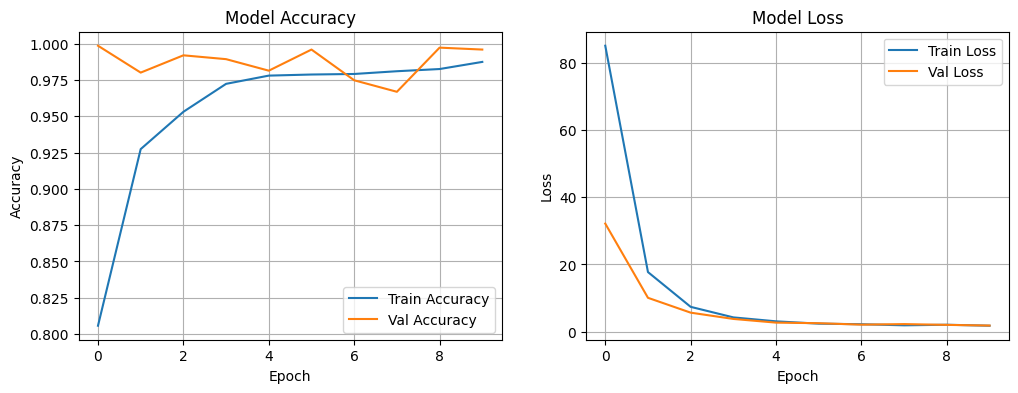

In [25]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.grid()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.grid()
plt.show()

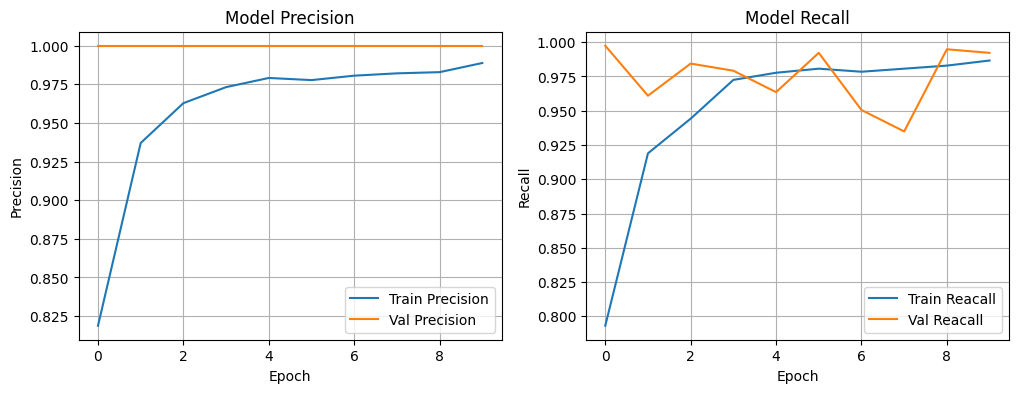

In [26]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['precision'], label='Train Precision')
plt.plot(history.history['val_precision'], label='Val Precision')
plt.title('Model Precision')
plt.ylabel('Precision')
plt.xlabel('Epoch')
plt.legend()
plt.grid()
plt.subplot(1, 2, 2)
plt.plot(history.history['recall'], label='Train Reacall')
plt.plot(history.history['val_recall'], label='Val Reacall')
plt.title('Model Recall')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.legend()
plt.grid()
plt.show()

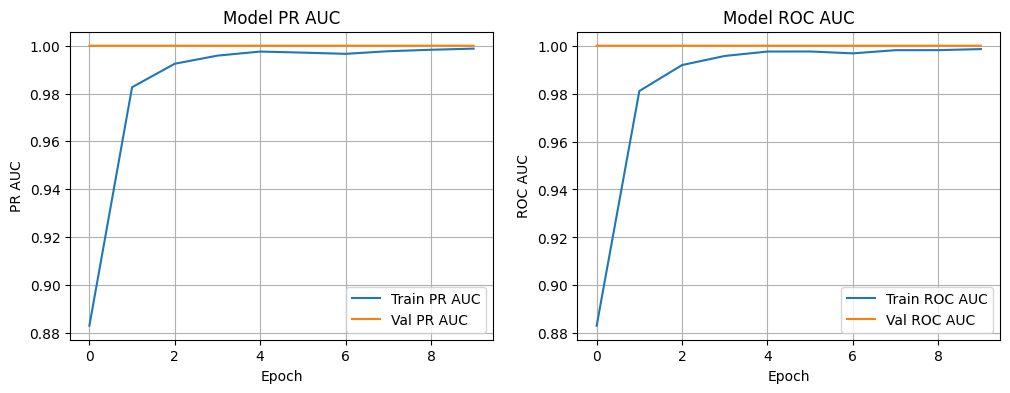

In [27]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['pr_auc'], label='Train PR AUC')
plt.plot(history.history['val_pr_auc'], label='Val PR AUC')
plt.title('Model PR AUC')
plt.ylabel('PR AUC')
plt.xlabel('Epoch')
plt.legend()
plt.grid()
plt.subplot(1, 2, 2)
plt.plot(history.history['roc_auc'], label='Train ROC AUC')
plt.plot(history.history['val_roc_auc'], label='Val ROC AUC')
plt.title('Model ROC AUC')
plt.ylabel('ROC AUC')
plt.xlabel('Epoch')
plt.legend()
plt.grid()
plt.show()

In [28]:
# Fine-tuning callbacks
ft_early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_pr_auc',
                                              mode='max',
                                              patience=5,
                                              restore_best_weights=True)

ft_checkpoint = tf.keras.callbacks.ModelCheckpoint('best_ft.keras',
                                                monitor='val_pr_auc',
                                                save_best_only=True,
                                                mode='max')

In [29]:
base = tf.keras.applications.ResNet50(
    include_top=False,
    weights='imagenet',
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)

base.trainable = True

inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))

x = base(inputs)

x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x)

x = layers.Dense(128,
                 activation='relu',
                 kernel_regularizer=regularizers.l2(0.01))(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.8)(x)

x = layers.Dense(64,
                 activation='relu',
                 kernel_regularizer=regularizers.l2(0.01))(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.8)(x)

x = layers.Dense(32,
                 activation='relu',
                 kernel_regularizer=regularizers.l2(0.01))(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.8)(x)
outputs = layers.Dense(1,
                       activation='sigmoid',
                       dtype='float32')(x)

resnet_model = tf.keras.Model(inputs, outputs)

In [30]:
# Fine-tuning: Unfreeze more layers
base.trainable = True
for layer in base.layers[:-50]:  # Unfreeze last 50 layers for better feature adaptation
    layer.trainable = False
for layer in base.layers[-50:]:  # Unfreeze first 50 layers for better feature adaptation
    layer.trainable = True

resnet_model.compile(
    optimizer=tf.keras.optimizers.AdamW(learning_rate=1e-5,
                                        weight_decay=1e-4),
    loss=tf.keras.losses.BinaryCrossentropy(label_smoothing=0.0),
    metrics=['accuracy',
             tf.keras.metrics.AUC(name='roc_auc'),
             tf.keras.metrics.AUC(name='pr_auc', curve='PR'),
             tf.keras.metrics.Precision(name='precision'),
             tf.keras.metrics.Recall(name='recall')]
)

In [31]:
fine_tune_history = resnet_model.fit(train_ds,
                                     validation_data=val_ds,
                                     callbacks=[ft_early_stop,
                                                ft_checkpoint],
                                     epochs=10,
                                     class_weight=class_weight
)

Epoch 1/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 185s 441ms/step - accuracy: 0.4987 - loss: 5.2098 - pr_auc: 0.4938 - precision: 0.4957 - recall: 0.4432 - roc_auc: 0.4998 - val_accuracy: 0.4907 - val_loss: 4.4478 - val_pr_auc: 0.4963 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_roc_auc: 0.5174
Epoch 2/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 161s 415ms/step - accuracy: 0.5043 - loss: 5.2585 - pr_auc: 0.5028 - precision: 0.5159 - recall: 0.4357 - roc_auc: 0.4950 - val_accuracy: 0.4921 - val_loss: 4.5403 - val_pr_auc: 0.7369 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_roc_auc: 0.7506
Epoch 3/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 166s 512ms/step - accuracy: 0.5577 - loss: 4.9724 - pr_auc: 0.5760 - precision: 0.5644 - recall: 0.4933 - roc_auc: 0.5816 - val_accuracy: 0.4921 - val_loss: 4.6137 - val_pr_auc: 0.8412 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_roc_auc: 0.8199
Epoch 4/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 166s 503ms/step - accuracy: 0.5566 - loss: 4.9604 - pr_auc: 0.5942 -

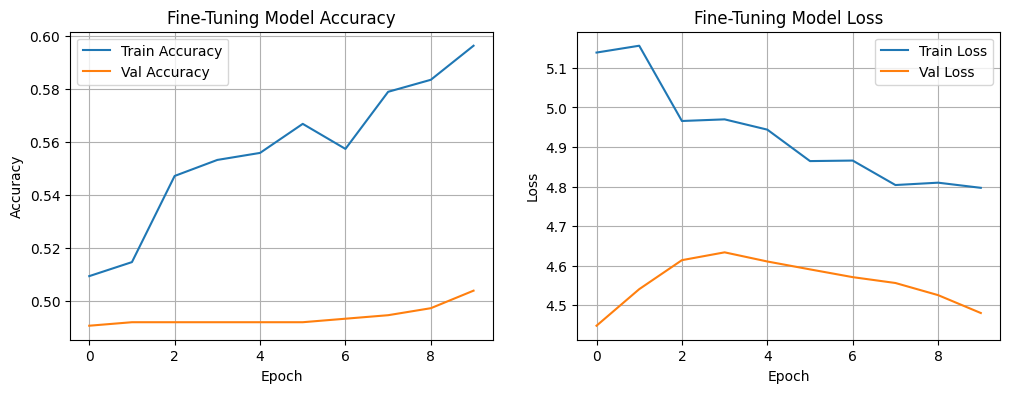

In [32]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(fine_tune_history.history['accuracy'], label='Train Accuracy')
plt.plot(fine_tune_history.history['val_accuracy'], label='Val Accuracy')
plt.title('Fine-Tuning Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.grid()
plt.subplot(1, 2, 2)
plt.plot(fine_tune_history.history['loss'], label='Train Loss')
plt.plot(fine_tune_history.history['val_loss'], label='Val Loss')
plt.title('Fine-Tuning Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.grid()
plt.show()

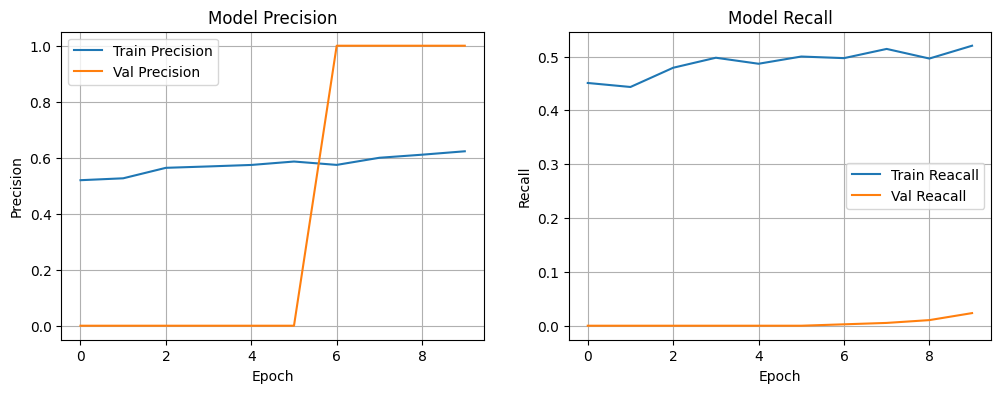

In [33]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(fine_tune_history.history['precision'], label='Train Precision')
plt.plot(fine_tune_history.history['val_precision'], label='Val Precision')
plt.title('Model Precision')
plt.ylabel('Precision')
plt.xlabel('Epoch')
plt.legend()
plt.grid()
plt.subplot(1, 2, 2)
plt.plot(fine_tune_history.history['recall'], label='Train Reacall')
plt.plot(fine_tune_history.history['val_recall'], label='Val Reacall')
plt.title('Model Recall')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.legend()
plt.grid()
plt.show()

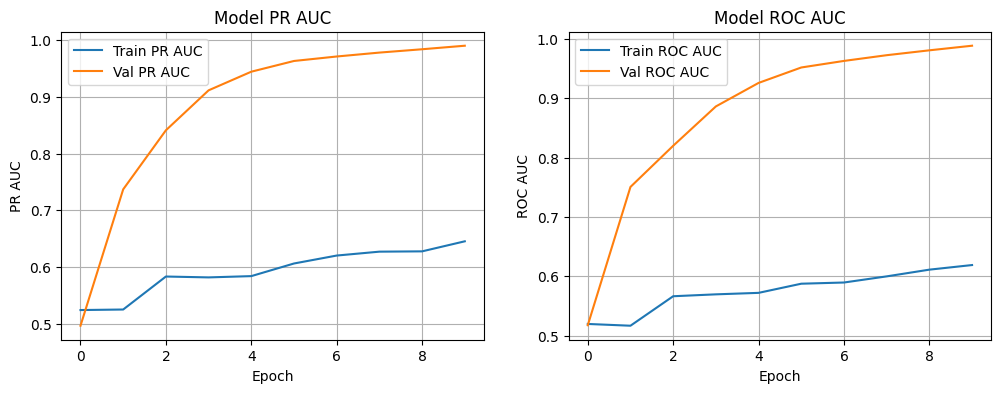

In [34]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(fine_tune_history.history['pr_auc'], label='Train PR AUC')
plt.plot(fine_tune_history.history['val_pr_auc'], label='Val PR AUC')
plt.title('Model PR AUC')
plt.ylabel('PR AUC')
plt.xlabel('Epoch')
plt.legend()
plt.grid()
plt.subplot(1, 2, 2)
plt.plot(fine_tune_history.history['roc_auc'], label='Train ROC AUC')
plt.plot(fine_tune_history.history['val_roc_auc'], label='Val ROC AUC')
plt.title('Model ROC AUC')
plt.ylabel('ROC AUC')
plt.xlabel('Epoch')
plt.legend()
plt.grid()
plt.show()

In [35]:
# Load best checkpoint if needed
resnet_model = tf.keras.models.load_model('best_ft.keras')

# Evaluate on test set
test_loss, test_acc, test_roc_auc, test_pr_auc, test_precision, test_recall = resnet_model.evaluate(test_ds)
print(f"Test Accuracy: {test_acc}, ROC AUC: {test_roc_auc}, PR AUC: {test_pr_auc}, Precision: {test_precision}, Recall: {test_recall}")

6/6 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step - accuracy: 0.7965 - loss: 4.0558 - pr_auc: 0.5624 - precision: 0.4286 - recall: 0.0092 - roc_auc: 0.5655
Test Accuracy: 0.5567282438278198, ROC AUC: 0.9906049966812134, PR AUC: 0.9903590679168701, Precision: 1.0, Recall: 0.023255813866853714


In [36]:
# Validation threshold tuning
y_val_prob = resnet_model.predict(val_ds).ravel()
y_val = np.concatenate([y for _, y in val_ds], axis=0)
import sklearn.metrics
fpr, tpr, thr = sklearn.metrics.roc_curve(y_val, y_val_prob)
j = tpr - fpr
best_thr = thr[np.argmax(j)]
print(f"Best validation threshold (Youlden j): {best_thr:.3f}")

# Test evaluation at tunned threshold
y_true = []
y_pred = []

for images, labels in test_ds:
    preds = resnet_model.predict(images)
    y_pred.extend(preds.flatten())
    y_true.extend(labels.numpy())

y_true = np.array(y_true)
y_prob = np.array(y_pred)

# Apply tunned threshold
y_pred_bin = (y_prob >= best_thr).astype(int)

# F1 Score
f1 = f1_score(y_true, y_pred_bin)
print(f"Test F1 Score (thr-{best_thr:.3f}): {f1:.4f}")

12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 333ms/step
Best validation threshold (Youlden j): 0.116
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 132ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Test F1 Score (thr-0.116): 0.9510


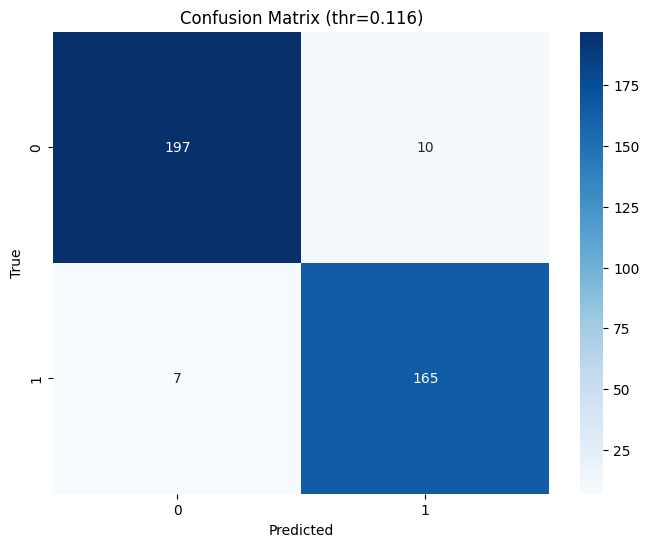

In [37]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred_bin)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title(f'Confusion Matrix (thr={best_thr:.3f})')
plt.show()

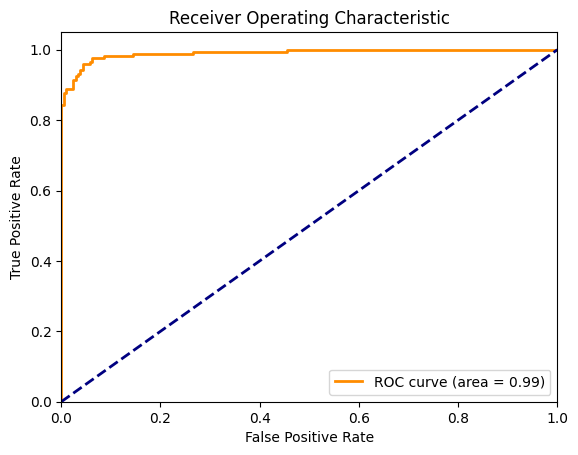

In [38]:
# ROC Curve
fpr, tpr, _ = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

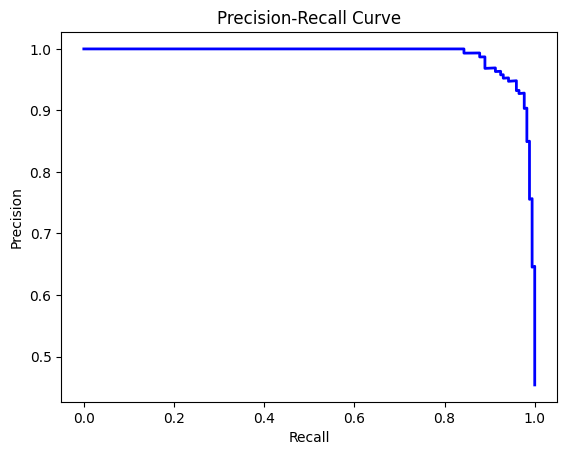

In [39]:
# PR Curve
precision, recall, _ = precision_recall_curve(y_true, y_pred)
plt.figure()
plt.plot(recall, precision, color='blue', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

In [40]:
resnet_model.save('wheat_model.keras')
resnet_model.save('wheat_model.h5')  # SavedModel format
print("Model saved as 'wheat_model.keras' and 'wheat_model'")

Model saved as 'wheat_model.keras' and 'wheat_model'


In [41]:
with open('model_summary.txt', 'w', encoding='utf-8') as f:
    resnet_model.summary(print_fn=lambda x: f.write(x + '\n'))
print("Model summary saved to 'model_summary.txt'")

Model summary saved to 'model_summary.txt'
